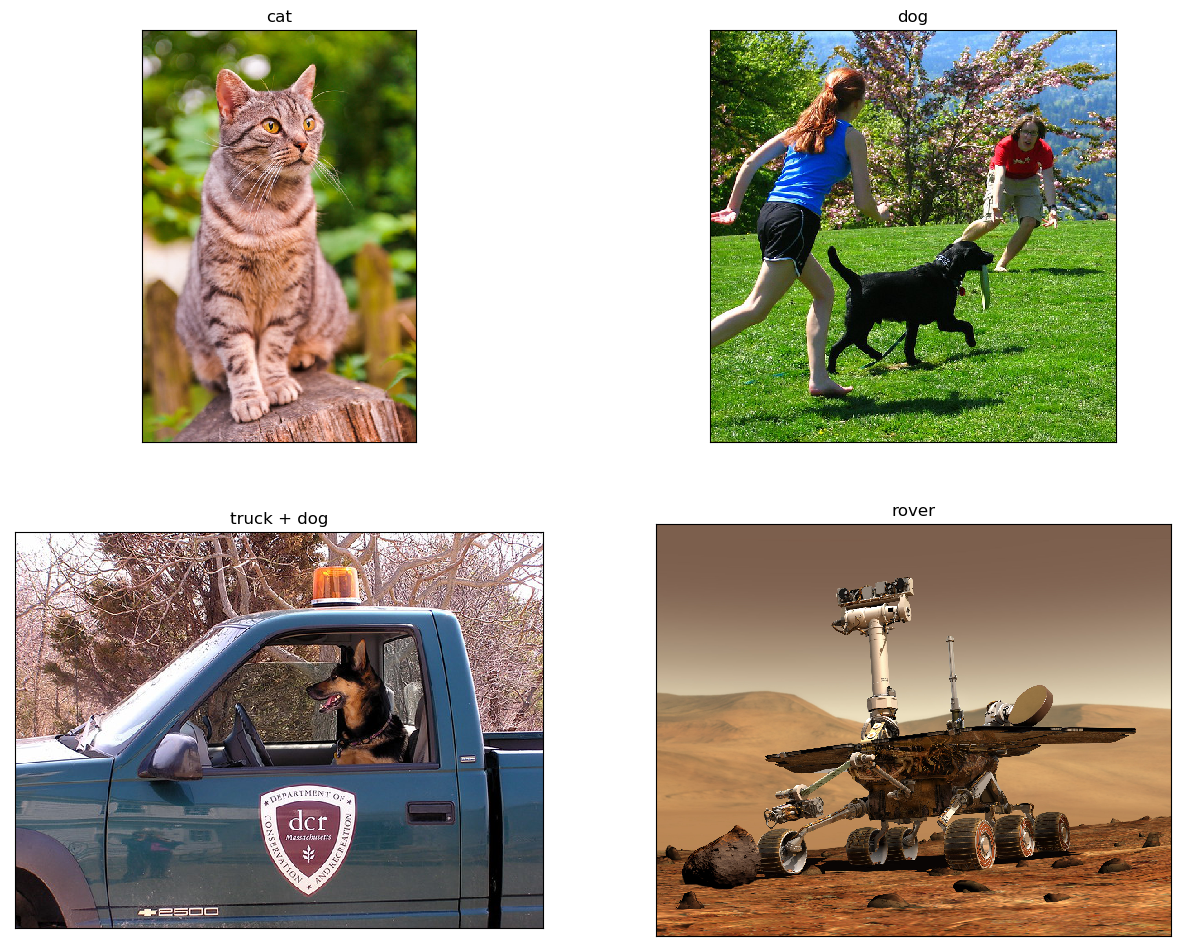

In [4]:
from utils import plot_image, load_tiny_batch, plot_images_grid

# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()
plot_images_grid(images_raw)

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

image_tensor = tf.placeholder(dtype='float32')

# Mean Inference Time on 4 CPUs = 459 ms
module = 'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'

# Mean Inference Time on 4 CPUs = 18.7 s
# module = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector_output = hub.Module(module)(image_tensor, as_dict=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0930 02:38:15.438998 140370280240960 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0930 02:38:22.709530 140370280240960 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [7]:
import numpy as np
image_input = np.expand_dims(np.array(images_raw['cat']) / 255, 0).astype('float32')
print(image_input.shape)

(1, 640, 427, 3)


In [9]:
import numpy as np

with tf.Session() as s:
    # Initializing the variables in the graph
    s.run([tf.global_variables_initializer(), tf.tables_initializer()])
    
    # Evaluating the detector's output with the image of the cat
    result_out = s.run(
        detector_output, 
        feed_dict={image_tensor: image_input}
    )

In [15]:
# Output is a dictionary, so let's look at the keys.
sorted(list(result_out.keys()))

['detection_boxes',
 'detection_class_entities',
 'detection_class_labels',
 'detection_class_names',
 'detection_scores']

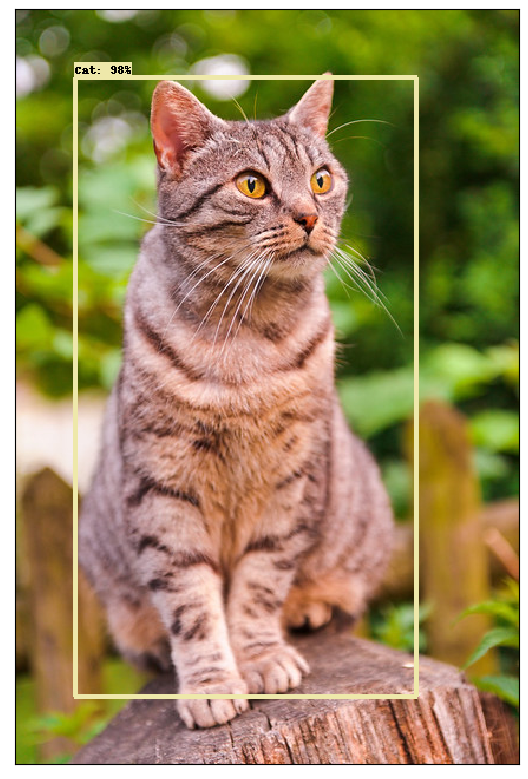

In [6]:
image_with_boxes = draw_boxes(
    np.array(images_raw['cat']), 
    result_out["detection_boxes"],
    result_out["detection_class_entities"], 
    result_out["detection_scores"],
    min_score=0.5
)

display_image(image_with_boxes)